# Population based metaheuristics - Flowshop problem

This notebook focuses on implementing some population-based algorithms to solve the flowshop problem. Population-based algorithms may find high-quality solutions within a reasonable amount of time.

### Table of content
- [Required functions](#Required-functions)
- [Genetic Algorithm](#Genetic-Algorithm)
- [Ant Colony Algorithm](#Ant-Colony-Algorithm)
- [Greedy NEH](#Greedy-NEH)
- [Hybrid GA with VNS](#Hybrid-GA-with-VNS)
- [Tests](#Tests)
- [Remarks](#Remarks)

### References
- [Benchmarks for Basic Scheduling Problems](http://mistic.heig-vd.ch/taillard/articles.dir/Taillard1993EJOR.pdf)
- [ACO-LS Algorithm for Solving No-wait Flow Shop
Scheduling Problem](https://sci-hub.se/10.1007/978-3-662-46742-8_8)

# Required functions

In [2]:
import numpy as np
import matplotlib as plt
import itertools
import time
import pandas as pd
import math
import random

In [3]:
def evaluate_sequence(sequence, processing_times):
    _, num_machines = processing_times.shape
    num_jobs = len(sequence)
    completion_times = np.zeros((num_jobs, num_machines))
    
    # Calculate the completion times for the first machine
    completion_times[0][0] = processing_times[sequence[0]][0]
    for i in range(1, num_jobs):
        completion_times[i][0] = completion_times[i-1][0] + processing_times[sequence[i]][0]
    
    # Calculate the completion times for the remaining machines
    for j in range(1, num_machines):
        completion_times[0][j] = completion_times[0][j-1] + processing_times[sequence[0]][j]
        for i in range(1, num_jobs):
            completion_times[i][j] = max(completion_times[i-1][j], completion_times[i][j-1]) + processing_times[sequence[i]][j]
    
    # Return the total completion time, which is the completion time of the last job in the last machine
    return completion_times[num_jobs-1][num_machines-1]

## CDS

In [4]:
def CDS_heuristic(processing_times):
    jobs, machines = processing_times.shape
    m = machines-1
    johnson_proc_times = np.zeros((jobs,2))
    best_cost = np.inf
    best_seq = []
    for k in range(m):
        johnson_proc_times[:,0] += processing_times[:,k]
        johnson_proc_times[:,1] += processing_times[:,-k-1]
        seq = johnson_method(johnson_proc_times)
        cost = evaluate_sequence(seq,processing_times)
        if cost < best_cost:
            best_cost = cost
            best_seq = seq
    return best_seq, best_cost

## Palmer

In [5]:
def palmer_heuristic(processing_times):
    jobs, machines = processing_times.shape
    f = []
    for i in range(jobs):
        fi = 0
        for j in range(machines):
            fi += (machines -2*j + 1) * processing_times[i][j]
        f.append(fi)
    order = sorted(range(jobs), key=lambda k: f[k])
    return order

## Gupta

In [6]:
def sign(x):
    if x > 0:
        return 1
    elif x < 0:
        return -1
    else:
        return 0
    
def min_gupta(job, processing_times):
    m = np.inf
    _, machines = processing_times.shape
    for i in range(machines-1):
        k = processing_times[job][i] + processing_times[job][i+1]
        if (k < m):
            m = k
    return k

def gupta_heuristic(processing_times):
    jobs, machines = processing_times.shape
    f = []
    for i in range(jobs):
        fi = sign(processing_times[i][0] - processing_times[i][machines-1]) / min_gupta(i,processing_times)
        f.append(fi)
    order = sorted(range(jobs), key=lambda k: f[k])
    return order

## Johnson

In [7]:
def johnson_method(processing_times):
    jobs, machines = processing_times.shape
    copy_processing_times = processing_times.copy()
    maximum = processing_times.max() + 1
    m1 = []
    m2 = []
    
    if machines != 2:
        raise Exception("Johson method only works with two machines")
        
    for i in range(jobs):
        minimum = copy_processing_times.min()
        position = np.where(copy_processing_times == minimum)
        
        if position[1][0] == 0:
            m1.append(position[0][0])
        else:
            m2.insert(0, position[0][0])
        
        copy_processing_times[position[0][0]] = maximum
        # Delete the job appended
        
    return m1+m2

## Artificial Heuristic

In [8]:
def artificial_heuristic(processing_times):
    jobs, machines = processing_times.shape
    r = 1
    best_cost = np.inf
    best_seq = []
    while r != machines :
        wi = np.zeros((jobs, machines - r))
        for i in range(jobs):
            for j in range(0, machines - r):
                wi[i, j] = (machines - r) - (j)
       
        am = np.zeros((jobs, 2))    
        am[:, 0] = np.sum(wi[:, :machines - r] * processing_times[:, :machines - r], axis=1)
        for i in range(jobs):
            for j in range(0, machines - r):
                am[i, 1] += wi[i, j ] * processing_times[i, machines - j - 1]

        seq = johnson_method(am)
        cost = evaluate_sequence(seq, processing_times)
        if cost < best_cost:
            best_cost = cost
            best_seq = seq
        r += 1
       
    return best_seq, best_cost

## NEH

In [9]:
def order_jobs_in_descending_order_of_total_completion_time(processing_times):
    total_completion_time = processing_times.sum(axis=1)
    return np.argsort(total_completion_time, axis=0).tolist()

def insertion(sequence, position, value):
    new_seq = sequence[:]
    new_seq.insert(position, value)
    return new_seq

def neh_algorithm(processing_times):
    ordered_sequence = order_jobs_in_descending_order_of_total_completion_time(processing_times)
    # Define the initial order
    J1, J2 = ordered_sequence[:2]
    sequence = [J1, J2] if evaluate_sequence([J1, J2], processing_times) < evaluate_sequence([J2, J1], processing_times) else [J2, J1]
    del ordered_sequence[:2]
    # Add remaining jobs
    for job in ordered_sequence:
        Cmax = float('inf')
        best_sequence = []
        for i in range(len(sequence)+1):
            new_sequence = insertion(sequence, i, job)
            Cmax_eval = evaluate_sequence(new_sequence, processing_times)
            if Cmax_eval < Cmax:
                Cmax = Cmax_eval
                best_sequence = new_sequence
        sequence = best_sequence
    return sequence, Cmax

## VNS

In [10]:
def swap(solution, i, k):
    temp = solution[k]
    solution[k] = solution[i]
    solution[i] = temp
    return solution

In [11]:
def random_swap(solution, processing_times):
    i = np.random.choice(list(solution))
    k = np.random.choice(list(solution))
    # Generating two different random positions
    while (i == k):
        k = np.random.choice(list(solution))
    # Switch between job i and job k in the given sequence
    neighbor = solution.copy()
    return swap(neighbor, i, k), evaluate_sequence(neighbor, processing_times)

In [12]:
def best_first_swap(solution, processing_times):
    # This function will take a solution, and return the first best solution.
    # The first solution that is better then the current one 'solution' in args.
    num_jobs = len(solution)
    best_cmax = evaluate_sequence(solution, processing_times)
    best_neighbor = solution.copy()
    for k1 in range(num_jobs):
        for k2 in range(k1+1, num_jobs):
            neighbor = solution.copy()
            neighbor = swap(neighbor,k1,k2)
            cmax = evaluate_sequence(neighbor, processing_times)
            if cmax < best_cmax:
                best_neighbor = neighbor
                best_cmax = cmax
                return best_neighbor, best_cmax
    return best_neighbor, best_cmax

In [13]:
def best_swap(solution, processing_times):
    # This function will take a solution, and return its best neighbor solution.
    num_jobs = len(solution)
    best_cmax = np.Infinity
    for k1 in range(num_jobs):
        for k2 in range(k1+1, num_jobs):
            neighbor = solution.copy()
            neighbor = swap(neighbor,k1,k2)
            cmax = evaluate_sequence(neighbor, processing_times)
            if cmax < best_cmax:
                best_neighbor = neighbor
                best_cmax = cmax
    return best_neighbor, best_cmax

In [14]:
def best_swaps(solution, processing_times):
    # This function will take a solution, and return a list that contains all solutions that are better than it.
    num_jobs = len(solution)
    cmax = evaluate_sequence(solution, processing_times)
    bests = []
    for k1 in range(num_jobs):
        for k2 in range(k1+1, num_jobs):
            neighbor = solution.copy()
            swap(neighbor,k1,k2)
            neighbor_cmax = evaluate_sequence(neighbor, processing_times)
            if neighbor_cmax < cmax:
                bests.append((neighbor_cmax, neighbor))
    bests.sort(key=lambda x: x[0])
    return bests

In [15]:
def random_insertion(solution, processing_times):
    # This function consists of choosing random two indices, i and k.
    # Remove the element at indice i, and insert it in the position k.
    i = np.random.choice(list(solution))
    k = np.random.choice(list(solution))
    while (i == k):
        k = np.random.choice(list(solution))
    neighbor = solution.copy()
    neighbor.remove(solution[i])
    neighbor.insert(k, solution[i])
    return neighbor, evaluate_sequence(neighbor, processing_times)

In [16]:
def best_insertion(solution, processing_times):
    # This function consists of trying all different insertions.
    # Then it returns the best one among them
    num_jobs = len(solution)
    best_cmax = np.Infinity
    for k1 in range(num_jobs):
        s = solution.copy()
        s_job = solution[k1]
        s.remove(s_job)
        for k2 in range(num_jobs):
            if k1 != k2:
                neighbor = s.copy()
                neighbor.insert(k2, s_job)
                cmax = evaluate_sequence(neighbor, processing_times)
                if cmax < best_cmax:
                    best_neighbor = neighbor
                    best_cmax = cmax
    return best_neighbor, best_cmax

In [17]:
def best_edge_insertion(solution, processing_times):
    num_jobs = len(solution)
    best_cmax = np.Infinity
    for k1 in range(num_jobs-1):
        s = solution.copy()
        s_job1 = s[k1] 
        s_job2 = s[k1+1]
        s.remove(s_job1)
        s.remove(s_job2)
        for k2 in range(num_jobs-1):
            if(k1 != k2):
                neighbor = s.copy()
                neighbor.insert(k2, s_job1)
                neighbor.insert(k2+1, s_job2)
                cmax = evaluate_sequence(neighbor, processing_times)
                if cmax < best_cmax:
                    best_neighbor = neighbor
                    best_cmax = cmax
    return best_neighbor, best_cmax

In [18]:
def get_neighbor(solution, processing_times, method="random_swap"):
    # Swapping methods
    if method == "random_swap":
        neighbor, cost = random_swap(solution, processing_times)
    elif method == "best_swap":
        neighbor, cost = best_swap(solution, processing_times)
    elif method == "best_first_swap":
        neighbor, cost = best_first_swap(solution, processing_times)
    # Insertion methods
    elif method == "random_insertion":
        neighbor, cost = random_insertion(solution, processing_times)
    elif method == "best_edge_insertion":
        neighbor, cost = best_edge_insertion(solution, processing_times)
    elif method == "best_insertion":
        neighbor, cost = best_insertion(solution, processing_times)
    # Randomly pick a method of generating neighbors.
    else:     
        i = random.randint(0, 5)
        if i == 0:
            neighbor, cost = random_swap(solution, processing_times)
        elif i == 1:
            neighbor, cost = best_swap(solution, processing_times)
        elif i == 2:
            neighbor, cost = best_first_swap(solution, processing_times)
        elif i == 3:
            neighbor, cost = random_insertion(solution, processing_times)
        elif i == 4:
            neighbor, cost = best_edge_insertion(solution, processing_times)
        else:
            neighbor, cost = best_insertion(solution, processing_times)
    return neighbor, cost

In [19]:
# This function performs a random perturbation on a list by swapping the elements of k adjacent positions.
# solution: the list to be perturbed
# k: the number of adjacent positions to be swapped
def shake_VNS(solution, k):
    n = len(solution)
    # If k is greater than the length of the list, then we create perturbations on all elements.
    indices = random.sample(range(n), min(k, n-1))
    indices.sort()
    neighbor = solution.copy()
    for i in indices:
        j = (i+k) % n
        neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
    return neighbor

In [20]:
def vns(sol_init, processing_times, max_iterations, k_max):
    num_jobs = len(sol_init)
    current_solution = sol_init
    current_cost = evaluate_sequence(current_solution, processing_times)
    k = 1
    iteration = 0
    while iteration < max_iterations:       
        # Appliquer la perturbation "shake" pour générer le voisin aléatoire
        best_neighbor_solution = shake_VNS(current_solution, k)
        best_neighbor_cost = evaluate_sequence(best_neighbor_solution, processing_times)
        
        # Parcourir les voisins pour trouver la meilleure solution locale
        for l in range(1, k_max+1):
            neighbor, neighbor_cost  = get_neighbor(current_solution, processing_times, method='random')
            if (neighbor_cost < best_neighbor_cost):
                best_neighbor_solution = neighbor
                best_neighbor_cost = neighbor_cost            
        
        # Si la meilleure solution trouvée dans le voisinage est meilleure que la solution courante
        # alors on met à jour la solution courante et on réinitialise le rayon de la recherche
        if ( best_neighbor_cost < current_cost ):
            current_solution = best_neighbor_solution
            current_cost = best_neighbor_cost
            k = 1
        else:
            k += 1
        iteration += 1
    return current_solution, current_cost

# Genetic Algorithm

In [21]:
def selection_GA(population, processing_times, n_selected, strategie):
    # case "roulette":
    if strategie == "roulette":
        fitness = [evaluate_sequence(seq, processing_times) for seq in population]
        fitness_sum = sum(fitness)
        selection_probs = [fitness[i]/fitness_sum for i in range(len(population))]
        cum_probs = [sum(selection_probs[:i+1]) for i in range(len(population))]
        selected = []
        for i in range(n_selected):
            while True:
                rand = random.random()
                for j, cum_prob in enumerate(cum_probs):
                    if rand < cum_prob:
                        break
                if population[j] not in selected:
                    selected.append(population[j])
                    break
    # case "Elitism":
    elif strategie == "Elitism":
        fitness = [evaluate_sequence(seq, processing_times) for seq in population]
        sorted_population = [x for x, _ in sorted(zip(population, fitness), key=lambda pair: pair[1], reverse=False)]
        selected = sorted_population[:n_selected]

    # case "rank":
    elif strategie == "rank":
        fitness = [evaluate_sequence(seq, processing_times) for seq in population]
        sorted_population = sorted(population, key = lambda x: fitness[population.index(x)])
        fitness_sum = sum(i+1 for i in range(len(sorted_population)))
        selection_probs = [(len(sorted_population)-i)/fitness_sum for i in range(len(sorted_population))]
        selected = []
        for i in range(n_selected):
            selected_index = random.choices(range(len(sorted_population)), weights=selection_probs)[0]
            selected.append(sorted_population[selected_index])
            sorted_population.pop(selected_index)
            selection_probs.pop(selected_index)
            
    # case "tournament":
    elif strategie == "tournament":
        k = 2
        selected = []
        for i in range(n_selected):
            while True:
                tournament = random.sample(population, k)
                tournament = [seq for seq in tournament if seq not in selected]
                if tournament:
                    break
            fitness = [evaluate_sequence(seq, processing_times) for seq in tournament]
            selected.append(tournament[fitness.index(min(fitness))])

    return selected

In [22]:
def crossover_GA(p1, p2, points):
    jobs = len(p1) - 1
    # One points crossover
    if points == 'ONE':
        point = random.randint(0, jobs)
        offspring1 = p1[:point] + p2[point:]
        offspring2 = p2[:point] + p1[point:]
        points = [point]
    else: # Two Points crossover
        point_1 = random.randint(0, jobs)
        point_2 = random.randint(0, jobs)
        if point_1 > point_2:
            point_1, point_2 = point_2, point_1
        offspring1 = p1[:point_1] + p2[point_1:point_2] + p1[point_2:]
        offspring2 = p2[:point_1] + p1[point_1:point_2] + p2[point_2:]
        points = [point_1, point_2]
    # Remove duplicates and replace with genes from the other offspring
    offspring1 = remove_duplicates_GA(offspring1, offspring2, points)
    offspring2 = remove_duplicates_GA(offspring2, offspring1, points)
    return offspring1, offspring2

def remove_duplicates_GA(offspring, other_offspring, points):
    jobs = len(offspring) - 1
    check_points = len(points) > 1
    while True:
        duplicates = set([job for job in offspring if offspring.count(job) > 1])
        if not duplicates:
            break
        for job in duplicates:
            pos = [i for i, x in enumerate(offspring) if x == job]
            if (check_points and ((pos[0] < points[0]) or (pos[0] >= points[1])) ) or  ( (pos[0] < points[0]) and not check_points):
                dup = pos[0]
                index = pos[1]
            else:
                dup = pos[1]
                index = pos[0]

            offspring[dup] = other_offspring[index]
    return offspring

In [23]:
def mutation_GA(sequence, mutation_rate):
    num_jobs = len(sequence)
    for i in range(num_jobs):
        r = random.random()
        if r < mutation_rate:
            available_jobs = [j for j in range(num_jobs) if j != sequence[i]]
            newjob = random.sample(available_jobs, 1)[0]
            sequence[sequence.index(newjob)] = sequence[i]
            sequence[i] = newjob
    return sequence

In [24]:
def genetic_algorithm(processing_times, init_pop, pop_size, select_pop_size, selection_method, cossover, mutation_probability, num_iterations):
    # Init population generation
    population = init_pop
    best_seq = selection_GA(population, processing_times, 1, "Elitism")[0]
    best_cost = evaluate_sequence(best_seq, processing_times)
    for i in range(num_iterations):
        # Selection
        s = int(select_pop_size * pop_size) # number of selected individus to be parents (%)
        parents = selection_GA(population, processing_times, s, selection_method)
        # Crossover
        new_generation = []
        for _ in range(0, pop_size, 2):
            parent1 = random.choice(parents)
            parent2 = random.choice([p for p in parents if p != parent1])
            child1, child2 = crossover_GA(parent1, parent2, cossover)
            new_generation.append(child1)
            new_generation.append(child2)

        new_generation = new_generation[:pop_size]
        # Mutation
        for i in range(pop_size):
            if random.uniform(0, 1) < mutation_probability:
                new_generation[i] = mutation_GA(new_generation[i], mutation_probability)
        # Replacement
        population = new_generation

        # checking for best seq in current population
        best_seq_pop = selection_GA(population, processing_times, 1, "Elitism")[0]
        best_cost_pop = evaluate_sequence(best_seq_pop, processing_times)
        if best_cost_pop < best_cost:
            best_seq = best_seq_pop.copy()
            best_cost = best_cost_pop

    return best_seq, best_cost   

# Ant Colony Algorithm

In [26]:
def distance(i, j, processing_times):
    m = processing_times.shape[1]
    max_delay = 0
    for k in range(2, m):
        delay = np.sum(processing_times[i,1:k]) - np.sum(processing_times[j,1:k-1])
        if delay > max_delay:
            max_delay = delay
    return (processing_times[i, 0] + max(0, max_delay))

def ant_colony_optimization(num_ants, num_iterations, alpha, beta, evaporation_rate, Q, tau0, q0, processing_times):
    num_jobs = processing_times.shape[0]
    tau = np.ones((num_jobs, num_jobs)) * tau0
    best_schedule = None
    best_makespan = np.inf
    
    # visibility
    heuristic_values = np.array([ [1/distance(i, j, processing_times) if j != i else 0 for j in range(num_jobs)] for i in range(num_jobs)])
    for iteration in range(num_iterations): 
        sequences = []
        for ant in range(num_ants):
            current_job = np.random.randint(num_jobs)
            current_sequence = [current_job] 
            for job in range(num_jobs-1):
                unscheduled = [j for j in range(num_jobs) if j not in current_sequence]
                probabilities = np.zeros(len(unscheduled))
                
                for i, unscheduled_job in enumerate(unscheduled):
                    probabilities[i] = (tau[current_job, unscheduled_job]**alpha) * (heuristic_values[current_job, unscheduled_job]**beta)
                
                probabilities /= np.sum(probabilities)
                
                # pseudo-random-proportional
                q = random.random()
                if q < q0: # exploitation : choose the best
                    next_job = unscheduled[np.where( probabilities == np.max(probabilities))[0][0]]
                else: # exploration
                    next_job = np.random.choice(unscheduled, p=probabilities)
                    
                current_sequence.append(next_job)
                current_point = next_job
            
            makespan = evaluate_sequence(current_sequence, processing_times)
            sequences.append((current_sequence, makespan))
            
            if makespan < best_makespan:
                best_makespan = makespan
                best_schedule = current_sequence.copy()
        
        pheromone_delta =  np.zeros((num_jobs, num_jobs))
        for ant in range(num_ants):
            seq, ev = sequences[ant]
            for j in range(num_jobs-1):
                pheromone_delta[seq[j], seq[j+1]] += Q / ev
                             
        # Update pheromone  
        tau = tau * evaporation_rate + pheromone_delta
    
    return best_schedule, best_makespan

# Greedy NEH

At each step of the NEH method, instead of getting the best partial solution as the original NEH dictates, one out of the best five partial solutions is randomly chosen with equal probabilities. This way, high-quality individuals, yet different from each other, can be generated.

In [27]:
def greedy_neh_algorithm(processing_times, num_candidates, num_iterations):
    n = len(processing_times)
    ordered_sequence = order_jobs_in_descending_order_of_total_completion_time(processing_times)
    best_sequence = []
    best_cmax = float('inf')
    for i in range(num_iterations):
        partial_sequence = [ordered_sequence[0]]
        for k in range(1, n):
            candidates = []
            for job in ordered_sequence:
                if job not in partial_sequence:
                    for i in range(k+1):
                        candidate_sequence = insertion(partial_sequence, i, job)
                        candidate_cmax = evaluate_sequence(candidate_sequence, processing_times)
                        candidates.append((candidate_sequence, candidate_cmax))
            candidates.sort(key=lambda x: x[1])
            partial_sequence, cmax = random.choice(candidates[:num_candidates])
        if cmax < best_cmax:
                best_sequence = partial_sequence
                best_cmax = cmax
        ordered_sequence.append(ordered_sequence.pop(0))
    return best_sequence, best_cmax

We implement a second GRNEH that does not include the notion of iteration, which ultimately provides a solution that approaches optimality, in order to use it in population generation later.

In [28]:
def GRNEH(processing_times, num_candidates):
    n = len(processing_times)
    ordered_sequence = order_jobs_in_descending_order_of_total_completion_time(processing_times)
    partial_sequence = [ordered_sequence[0]]
    for k in range(1, n):
        candidates = []
        for job in ordered_sequence:
            if job not in partial_sequence:
                for i in range(k+1):
                    candidate_sequence = insertion(partial_sequence, i, job)
                    candidate_cmax = evaluate_sequence(candidate_sequence, processing_times)
                    candidates.append((candidate_sequence, candidate_cmax))
        candidates.sort(key=lambda x: x[1])
        partial_sequence, cmax = random.choice(candidates[:num_candidates])
    return partial_sequence, cmax

# Hybrid GA with VNS

Below is a schematic representation illustrating the hybridization process of Variable Neighborhood Search (VNS) and Genetic Algorithm (GA):
![Image description](Assets/hybrid.png)

## Generating an initial population

For our genetic algorithm, we implement a function to generate the initial population.
- **5** sequences generated by our heuristics
- **(a% * population size) - 5** sequences generated by GRNEH
- **(100 - a%) * population size** sequences generated randomly.

The article *Minimizing makespan in permutation flow shop scheduling problems using a hybrid metaheuristic algorithm* by **Zobolas et al** explains that the higher the value of a, the better the makespan of the final solution improves, but the longer the algorithm takes to converge.

In [29]:
def init_pop(processing_times, pop_size, a):
    
    #Les individus stockeront la séquence ( solution ), le makespan et un compteur c qui va déterminé si une solution est agée ou non
    population = []
    #Heuristics
    sol, cmax = neh_algorithm(processing_times)
    population.append(( sol, cmax ,0))
    sol, cmax = CDS_heuristic(processing_times)
    population.append(( sol, cmax ,0))
    sol=palmer_heuristic(processing_times)
    population.append((sol, evaluate_sequence(sol, processing_times),0))
    sol, cmax = artificial_heuristic(processing_times)
    population.append(( sol, cmax ,0))
    sol = gupta_heuristic(processing_times)
    population.append((sol, evaluate_sequence(sol, processing_times),0))
    
    #GRNEH
    for i in range(int(a*pop_size) - 5 ):
        sol, cmax = GRNEH(processing_times, 5)
        population.append(( sol, cmax ,0))
    
    #Random
    for i in range (int((1-a)*pop_size)):
        sol = np.random.permutation(processing_times.shape[0]).tolist() 
        population.append((sol, evaluate_sequence(sol, processing_times),0))
    
    return population

## Population improvement via GA

### Parents selection
To test our algorithm, we implemented four parent selection strategies, but we will use Tournament below because our algorithm includes an intensification phase, and the selection operator must ensure diversification

In [30]:
def selection(population, processing_times, n_selected, strategie):
    # case "roulette":
    if strategie == "roulette":
        fitness = [evaluate_sequence(seq, processing_times) for seq in population]
        fitness_sum = sum(fitness)
        selection_probs = [fitness[i]/fitness_sum for i in range(len(population))]
        cum_probs = [sum(selection_probs[:i+1]) for i in range(len(population))]
        selected = []
        for i in range(n_selected):
            while True:
                rand = random.random()
                for j, cum_prob in enumerate(cum_probs):
                    if rand < cum_prob:
                        break
                if population[j] not in selected:
                    selected.append(population[j])
                    break
    # case "Elitism":
    elif strategie == "Elitism":
        fitness = [evaluate_sequence(seq, processing_times) for seq in population]
        sorted_population = [x for x, _ in sorted(zip(population, fitness), key=lambda pair: pair[1], reverse=False)]
        selected = sorted_population[:n_selected]

    # case "rank":
    elif strategie == "rank":
        fitness = [evaluate_sequence(seq, processing_times) for seq in population]
        sorted_population = sorted(population, key = lambda x: fitness[population.index(x)])
        fitness_sum = sum(i+1 for i in range(len(sorted_population)))
        selection_probs = [(len(sorted_population)-i)/fitness_sum for i in range(len(sorted_population))]
        selected = []
        for i in range(n_selected):
            selected_index = random.choices(range(len(sorted_population)), weights=selection_probs)[0]
            selected.append(sorted_population[selected_index])
            sorted_population.pop(selected_index)
            selection_probs.pop(selected_index)
            
    # case "tournament":
    elif strategie == "tournament":
        #a random number of solutions is selected at first, ranging from 3 to 10.
        k = random.randint(3, 10)
        selected = []
        for i in range(n_selected):
            while True:
                tournament = random.sample(population, k)
                tournament = [seq for seq in tournament if seq not in selected]
                if tournament:
                    break
            selected.append(min(tournament, key=lambda x: x[1]))

    return selected

### Crossing of parents
In the article *Genetic algorithms for flowshop scheduling problems. Computers and Industrial Engineering* by **Murata T, Ishibuchi H, Tanaka H**, it was found that the best crossover operator for PFSP (Permutation Flowshop Scheduling Problems) is the **two-point crossover version I**.

In [31]:
def tp_crossover(parent1, parent2, processing_times):
    jobs = len(processing_times) - 1
    point1 = random.randint(0, jobs)
    point2 = random.randint(0, jobs)
    
    while point1 == point2 or point1 == (point2-1) or (point1 == point2+1) : 
        point2 = random.randint(0, jobs)
        
    if point1 > point2:
        point1, point2 = point2, point1

    # Create offspring as copies of parents
    offspring1 = parent1[0].copy()
    offspring2 = parent2[0].copy()

     # Set the segment between point1 and point2 to empty in offspring1
    offspring1[point1:point2] = [None] * (point2 - point1)

     # Set the segment between point1 and point2 to empty in offspring2
    offspring2[point1:point2] = [None] * (point2 - point1)
    
    # Remove duplicates from offspring1 and copy remaining genes from parent2
    for gene in parent2[0]:
         if gene not in offspring1:
            offspring1[offspring1.index(None)] = gene
            
    # Remove duplicates from offspring2 and copy remaining genes from parent1
    for gene in parent1[0]:
         if gene not in offspring2:
            offspring2[offspring2.index(None)] = gene
    
    return offspring1, offspring2

### Mutation of offspring
Both articles, **Ruiz R, Maroto C, Alcaraz J.**: *Two new robust genetic algorithms for the flowshop scheduling problem. Omega—International Journal of Management Science* and *Computers and Industrial Engineering* by **Murata T, Ishibuchi H, Tanaka H.**, have shown that the best operator for PFSP is a shift mutation, which means a random insertion.

In [32]:
def random_insertion(solution, processing_times):
    # This function consists of choosing random two indices, i and k.
    # Remove the element at indice i, and insert it in the position k.
    i = np.random.choice(list(solution))
    k = np.random.choice(list(solution))
    while (i == k):
        k = np.random.choice(list(solution))
    neighbor = solution.copy()
    neighbor.remove(solution[i])
    neighbor.insert(k, solution[i])
    return neighbor, evaluate_sequence(neighbor, processing_times)

### Updating the population
The best performing offspring are included in the new population because, according to **Ruiz R, Maroto C, and Alcaraz J.**, this selection performs better than directly replacing parents. Therefore, we replace the worst individuals in the population with the best unique offspring. In order to avoid premature convergence, we only accept a new solution in a population if it is not already present in the population.

In [33]:
def sol_unique(population, solution): 
    for p in population:
        if p[0] == solution:
            return False
    return True

def replace_sol(population, old_sol, new_sol):
    for i in range(len(population)):
        if (population[i] == old_sol):
            population[i] = new_sol
            return
    return  

def replace_with_offspring(population, offspring):
    #Vérifier que l'offspring n'existe pas déjà dans la population
    if (sol_unique(population, offspring[0])==False): 
        return

    #Si il est unique, on prend le pire individu de la population courante
    worst_ind = max(population, key=lambda x: x[1])
    if worst_ind[1] > offspring[1]:
        replace_sol(population, worst_ind, offspring)
        
    return  

## Complete genetic algorithm

In [34]:
def AG(population, processing_times):
    children = []
    #génération des enfants
    for i in range(int(len(population)/2)):
        mating_pool = selection(population, processing_times, 2, "tournament")
        os1, os2 = tp_crossover(mating_pool[0], mating_pool[1], processing_times)
        os1, fit1 = random_insertion(os1, processing_times)
        os2, fit2 = random_insertion(os2, processing_times)
        children.append((os1, fit1, 0))
        children.append((os2, fit2, 0))
   
    #remplacement dans la population
    for child in children: 
        replace_with_offspring(population, child)
    return

## Intensification
At this stage, we apply a VNS local search on a selected sub-population to complement the genetic algorithm

### VNS operators 
The main idea behind intensification here is that simpler neighborhood structures should be explored first (i.e., random swap and random insertion) before moving on to more complex ones (i.e., 2-opt and or-opt).

In [35]:
def swap(solution, i, k):
    temp = solution[k]
    solution[k] = solution[i]
    solution[i] = temp
    return solution

In [36]:
def random_swap(solution, processing_times):
    i = np.random.choice(list(solution))
    k = np.random.choice(list(solution))
    # Generating two different random positions
    while (i == k):
        k = np.random.choice(list(solution))
    # Switch between job i and job k in the given sequence
    neighbor = solution.copy()
    return swap(neighbor, i, k), evaluate_sequence(neighbor, processing_times)

In [37]:
def or_opt(solution, lenInterv, processing_times): 
    num_jobs = len(processing_times)
    
    # [i,j] les positions respectives des éléments à déplacer dans la séquence de la solution
    i = random.randint(0, num_jobs - lenInterv)
    j = i + lenInterv
        
    #sélectionner k, la position où insérer la séquence déplacée
    k = random.randint(0, num_jobs-1)

    neighbor = solution.copy()
    # Extraire la séquence entre i et j
    seq = neighbor[i:j+1]
    
    # Retirer la séquence de la solution
    neighbor = neighbor[:i] + neighbor[j+1:]
    
    # Insérer la séquence après k
    neighbor = neighbor[:k+1] + seq + neighbor[k+1:]
    
    return neighbor, evaluate_sequence(neighbor, processing_times)

In [38]:
def two_opt(solution, lenInterv, processing_times):
    
    num_jobs = len(processing_times)
    # [i,j] les positions respectives des éléments à déplacer dans la séquence de la solution
    i = random.randint(0, num_jobs - lenInterv)
    j = i + lenInterv
    
    #sélectionner k, la position où insérer la séquence déplacée
    k = random.randint(0, num_jobs-1)
    
    neighbor = solution.copy()
    # Extraire la séquence entre i et j et l'inverser
    seq = list(reversed(neighbor[i:j+1]))
    
    # Retirer la séquence de la solution
    neighbor = neighbor[:i] + neighbor[j+1:]

    # Insérer la séquence après k
    neighbor = neighbor[:k+1] + seq + neighbor[k+1:]
    
    return neighbor, evaluate_sequence(neighbor, processing_times)

### Perturbation function
This function performs a random perturbation on a list by exchanging the elements of k adjacent positions.

In [39]:
# solution: la liste à perturber
# k: le nombre de positions adjacentes à échanger

def shake(solution, k):
    n = len(solution)
    # Si k supérieur à la longueur de la liste, alors on crée des perturbations sur tous les éléments.
    indices = random.sample(range(n), min(k, n-1))
    indices.sort()
    neighbor = solution.copy()
    for i in indices:
        j = (i+k) % n
        neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
    return neighbor

In [40]:
def intensification(population, processing_times):
    
    #On commence par sélectionner la sous-population sur laquelle on appliquera l'intensification    
    #La taille de la sous_pop est égale au nombre de jobs. 
    num_jobs = len(processing_times)
    
    #La moitié de la sous-population est représentée par les meilleurs solutions.
    population.sort(key=lambda x: x[1])
    sous_pop = population[:int(num_jobs/2)]
    
    #l'autre moitié sera choisie au hasard
    choix = population[int(num_jobs/2):]
    seq = random.sample(choix, int(num_jobs/2))
    sous_pop = sous_pop + seq

    
    #Maintenant nous allons appliquer un VNS sur chacune des populations résultantes
    for S in sous_pop:
        #Si la solution est considérée comme ancienne, nous la remplaçons par une solution gérérée par GRNEH sans itérations
        #Sauf pour la meilleure solution courrante
        if (S[2]>=8): 
            if (S != min(population, key=lambda x: x[1])):
                sol, cmax = GRNEH(processing_times, 5)
                B = (sol, cmax, 0)
                while (sol_unique(population, B[0])==False): 
                    B = (shake(B[0], 1), evaluate_sequence(B[0], processing_times), 0)
                replace_sol ( population, S, B)
        
        else:
            #B va stocker l'optimum local trouvé par VNS
            B = S 
                
            if ( 4 <= S[2] < 8 ):
                B = ( shake(B[0], 2), evaluate_sequence(B[0], processing_times), B[2])
        
            for loop in range ( (num_jobs)*(num_jobs-1) ):
                if (S[2]== 0 or S[2]== 4): 
                    sol, cmax = random_swap(B[0], processing_times)
                    ST = (sol, cmax, 0)
                if (S[2]== 1 or S[2]== 5):
                    sol, cmax = random_insertion(B[0], processing_times)
                    ST = (sol, cmax, 0)
                if (S[2]== 2 or S[2]== 6): 
                    sol, cmax = or_opt(B[0], 3, processing_times)
                    ST = (sol, cmax, 0)
                if (S[2]== 3 or S[2]== 7):
                    sol, cmax = two_opt(B[0], 3, processing_times)
                    ST = (sol, cmax, 0)
                if ( ST[1] <= B[1] ): 
                    B = ST
         
        #Si l'optimum local retournée par VNS améliore la solution i, alors on vérifie qu'il est unique puis on remplace
        #OBSERVATION : Si on met <=, on aura toujours des remplacement et bcp de solution semblable
            if ( B[1] < S[1] ): 
                if (sol_unique(population, B[0])): 
                    replace_sol ( population, S, B)

                else:
                    replace_sol ( population, S, (S[0], S[1], S[2]+1))        

            else: 
                replace_sol ( population, S, (S[0], S[1], S[2]+1))        
    
    best_indiv = min(population, key=lambda x: x[1])
    
    return best_indiv[0], best_indiv[1]

In [41]:
def NEGA(population, processing_times, num_iterations):
    for i in range(num_iterations):
        AG(population, processing_times)
        best_sol, best_fitness = intensification(population, processing_times)
    return best_sol, best_fitness

# Tests on Taillard instances

## Reading Taillard instances

In [42]:
# Open the file that contains the instances
file = open("Benchmarks/tai20_5.txt", "r")

# Read the file line by line to retrieve the instances
n = 0
instances_20_5 = [[]]
line = file.readline()

while line:
    if line != '\n':
        line = line.strip(' ')
        line = line[:-1]
        line = line.split()
        line = [int(num) for num in line]
        instances_20_5[n].append(line)
    else:
        instances_20_5.append([])
        n += 1
    line = file.readline()
    
print(f'Taillard, 20 jobs 5 machines contains {len(instances_20_5)} benchmark.')  

Taillard, 20 jobs 5 machines contains 10 benchmark.


In [43]:
instance_20_5_0 = np.array(instances_20_5[0])
instance_20_5_0 = instance_20_5_0.T

In [44]:
instance_20_5_1 = np.array(instances_20_5[1])
instance_20_5_1 = instance_20_5_1.T

In [45]:
instance_20_5_4 = np.array(instances_20_5[4])
instance_20_5_4 = instance_20_5_4.T

In [46]:
instance_20_5_6 = np.array(instances_20_5[6])
instance_20_5_6 = instance_20_5_6.T

In [47]:
instance_common = np.array([
    [71, 79, 85, 82, 83], 
    [84, 71, 66, 68, 81],
    [78, 81, 75, 72, 87],
    [78, 75, 66, 72, 88],
    [72, 88, 83, 85, 88],
    [86, 88, 79, 82, 78],
    [75, 66, 86, 78, 78],
    [80, 79, 66, 83, 78],
    [73, 73, 67, 77, 71],
    [80, 77, 83, 78, 67],
])

In [51]:
Hybrid = ['Hybrid Algorithm']
GA = ['Genetic Algorithm']
ACO = ['Ant colony']
NEH = ['NEH']
GNEH = ['Greedy NEH']
AH = ['Artificial heuristic']
VNS = ['VNS']

## Hybrid GA and VNS Algorithm

### Common instance

In [52]:
popul = init_pop(instance_common, 50, 0.5)
start_time = time.time()
Best_solution, Best_makespan = NEGA(popul, instance_common, 5)
elapsed_time = time.time() - start_time

print(f'Solution: {Best_solution}.')
print(f'\nCmax: {Best_makespan}')
print("\nElapsed time: ", elapsed_time, "seconds")

Hybrid.append("%.3f" % (Best_makespan))
Hybrid.append(" %.3fs" % (elapsed_time))

Solution: [3, 6, 2, 0, 8, 1, 4, 7, 5, 9].

Cmax: 1104.0

Elapsed time:  0.5044906139373779 seconds


### First instance of the 20_5 benchmark

In [54]:
popul = init_pop(instance_20_5_0, 50, 0.5)
start_time = time.time()
Best_solution, Best_makespan = NEGA(popul, instance_20_5_0, 5)
elapsed_time = time.time() - start_time

print(f'Solution: {Best_solution}.')
print(f'\nCmax: {Best_makespan}')
print("\nElapsed time: ", elapsed_time, "seconds")

Hybrid.append("%.3f" % (Best_makespan))
Hybrid.append(" %.3fs" % (elapsed_time))

Solution: [8, 14, 16, 13, 2, 5, 4, 6, 7, 15, 10, 12, 17, 3, 1, 18, 0, 9, 19, 11].

Cmax: 1278.0

Elapsed time:  7.04775595664978 seconds


### Second instance of the 20_5 benchmark

In [57]:
popul = init_pop(instance_20_5_1, 50, 0.5)
start_time = time.time()
Best_solution, Best_makespan = NEGA(popul, instance_20_5_1, 6)
elapsed_time = time.time() - start_time

print(f'Solution: {Best_solution}.')
print(f'\nCmax: {Best_makespan}')
print("\nElapsed time: ", elapsed_time, "seconds")

Hybrid.append("%.3f" % (Best_makespan))
Hybrid.append(" %.3fs" % (elapsed_time))

Solution: [5, 9, 16, 6, 2, 18, 14, 0, 13, 15, 8, 17, 19, 10, 4, 7, 11, 12, 3, 1].

Cmax: 1359.0

Elapsed time:  9.15480661392212 seconds


### Fifth instance of the 20_5 benchmark

In [58]:
popul = init_pop(instance_20_5_4, 50, 0.5)
start_time = time.time()
Best_solution, Best_makespan = NEGA(popul, instance_20_5_4, 5)
elapsed_time = time.time() - start_time

print(f'Solution: {Best_solution}.')
print(f'\nCmax: {Best_makespan}')
print("\nElapsed time: ", elapsed_time, "seconds")

Hybrid.append("%.3f" % (Best_makespan))
Hybrid.append(" %.3fs" % (elapsed_time))

Solution: [11, 3, 9, 16, 18, 8, 4, 2, 15, 1, 12, 5, 10, 14, 13, 6, 17, 0, 19, 7].

Cmax: 1235.0

Elapsed time:  7.585740089416504 seconds


### Seventh instance of the 20_5 benchmark

In [59]:
popul = init_pop(instance_20_5_6, 50, 0.5)
start_time = time.time()
Best_solution, Best_makespan = NEGA(popul, instance_20_5_6, 6)
elapsed_time = time.time() - start_time

print(f'Solution: {Best_solution}.')
print(f'\nCmax: {Best_makespan}')
print("\nElapsed time: ", elapsed_time, "seconds")

Hybrid.append("%.3f" % (Best_makespan))
Hybrid.append(" %.3fs" % (elapsed_time))

Solution: [9, 12, 0, 19, 3, 1, 14, 2, 10, 8, 16, 11, 7, 4, 5, 18, 13, 15, 6, 17].

Cmax: 1239.0

Elapsed time:  9.022180080413818 seconds


## Genetic algorithm

### Common instance

In [63]:
pop_size = 30
select_pop_size = 0.5
selection_method = "roulette"
cossover = "TWO"
mutation_probability = .5
num_iterations = 100

# Checking parameters
s = int(select_pop_size * pop_size)
try:
    if s < 2:
        raise ValueError("there should be at least two selected parents : please increase the % of selection")
    comb = math.comb(s, 2) * 2
    if comb < pop_size:
        raise ValueError("The maximum size of population with the choosed parameters is "+str(comb)+" sequences : please increase the % of selection or decrease the size of population")   
    init_pop = [np.random.permutation(instance_common.shape[0]).tolist() for i in range(pop_size)]
    start_time = time.time()
    best_solution, best_solution_cost = genetic_algorithm(instance_common, init_pop, pop_size, select_pop_size, selection_method, cossover, mutation_probability, num_iterations)
    elapsed_time = time.time() - start_time
    print(f'Best sequence found by genetic algorithm is {best_solution} with a makespan of {best_solution_cost}')
    print("Elapsed time:", elapsed_time, "seconds")      
except ValueError as e:
    print(e)
    
GA.append("%.3f" % (best_solution_cost))
GA.append(" %.3fs" % (elapsed_time))

Best sequence found by genetic algorithm is [2, 3, 6, 4, 0, 8, 1, 7, 9, 5] with a makespan of 1107.0
Elapsed time: 0.5466396808624268 seconds


### First instance of the 20_5 benchmark

In [74]:
pop_size = 30
select_pop_size = 0.5
selection_method = "roulette"
cossover = "TWO"
mutation_probability = .5
num_iterations = 100

# Checking parameters
s = int(select_pop_size * pop_size)
try:
    if s < 2:
        raise ValueError("there should be at least two selected parents : please increase the % of selection")
    comb = math.comb(s, 2) * 2
    if comb < pop_size:
        raise ValueError("The maximum size of population with the choosed parameters is "+str(comb)+" sequences : please increase the % of selection or decrease the size of population")   
    init_pop = [np.random.permutation(instance_20_5_0.shape[0]).tolist() for i in range(pop_size)]
    start_time = time.time()
    best_solution, best_solution_cost = genetic_algorithm(instance_20_5_0, init_pop, pop_size, select_pop_size, selection_method, cossover, mutation_probability, num_iterations)
    elapsed_time = time.time() - start_time
    print(f'Best sequence found by genetic algorithm is {best_solution} with a makespan of {best_solution_cost}')
    print("Elapsed time:", elapsed_time, "seconds")      
except ValueError as e:
    print(e)
    
GA.append("%.3f" % (best_solution_cost))
GA.append(" %.3fs" % (elapsed_time))

Best sequence found by genetic algorithm is [0, 7, 10, 14, 4, 12, 8, 3, 9, 18, 6, 5, 13, 15, 16, 2, 11, 1, 17, 19] with a makespan of 1330.0
Elapsed time: 1.1288297176361084 seconds


### Second instance of the 20_5 benchmark

In [76]:
pop_size = 30
select_pop_size = 0.5
selection_method = "roulette"
cossover = "TWO"
mutation_probability = .5
num_iterations = 100

# Checking parameters
s = int(select_pop_size * pop_size)
try:
    if s < 2:
        raise ValueError("there should be at least two selected parents : please increase the % of selection")
    comb = math.comb(s, 2) * 2
    if comb < pop_size:
        raise ValueError("The maximum size of population with the choosed parameters is "+str(comb)+" sequences : please increase the % of selection or decrease the size of population")   
    init_pop = [np.random.permutation(instance_20_5_1.shape[0]).tolist() for i in range(pop_size)]
    start_time = time.time()
    best_solution, best_solution_cost = genetic_algorithm(instance_20_5_1, init_pop, pop_size, select_pop_size, selection_method, cossover, mutation_probability, num_iterations)
    elapsed_time = time.time() - start_time
    print(f'Best sequence found by genetic algorithm is {best_solution} with a makespan of {best_solution_cost}')
    print("Elapsed time:", elapsed_time, "seconds")      
except ValueError as e:
    print(e)

GA.append("%.3f" % (best_solution_cost))
GA.append(" %.3fs" % (elapsed_time))

Best sequence found by genetic algorithm is [14, 5, 6, 1, 10, 15, 11, 18, 3, 0, 16, 19, 4, 12, 7, 13, 17, 9, 8, 2] with a makespan of 1393.0
Elapsed time: 1.193434476852417 seconds


### Fifth instance of the 20_5 benchmark

In [86]:
pop_size = 30
select_pop_size = 0.5
selection_method = "roulette"
cossover = "TWO"
mutation_probability = .5
num_iterations = 100

# Checking parameters
s = int(select_pop_size * pop_size)
try:
    if s < 2:
        raise ValueError("there should be at least two selected parents : please increase the % of selection")
    comb = math.comb(s, 2) * 2
    if comb < pop_size:
        raise ValueError("The maximum size of population with the choosed parameters is "+str(comb)+" sequences : please increase the % of selection or decrease the size of population")   
    init_pop = [np.random.permutation(instance_20_5_4.shape[0]).tolist() for i in range(pop_size)]
    start_time = time.time()
    best_solution, best_solution_cost = genetic_algorithm(instance_20_5_4, init_pop, pop_size, select_pop_size, selection_method, cossover, mutation_probability, num_iterations)
    elapsed_time = time.time() - start_time
    print(f'Best sequence found by genetic algorithm is {best_solution} with a makespan of {best_solution_cost}')
    print("Elapsed time:", elapsed_time, "seconds")      
except ValueError as e:
    print(e)
    
GA.append("%.3f" % (best_solution_cost))
GA.append(" %.3fs" % (elapsed_time))

Best sequence found by genetic algorithm is [12, 8, 11, 15, 6, 2, 16, 14, 3, 19, 1, 18, 17, 4, 9, 13, 0, 5, 10, 7] with a makespan of 1311.0
Elapsed time: 1.0743556022644043 seconds


### Seventh instance of the 20_5 benchmark

In [87]:
pop_size = 30
select_pop_size = 0.5
selection_method = "roulette"
cossover = "TWO"
mutation_probability = .5
num_iterations = 100

# Checking parameters
s = int(select_pop_size * pop_size)
try:
    if s < 2:
        raise ValueError("there should be at least two selected parents : please increase the % of selection")
    comb = math.comb(s, 2) * 2
    if comb < pop_size:
        raise ValueError("The maximum size of population with the choosed parameters is "+str(comb)+" sequences : please increase the % of selection or decrease the size of population")   
    init_pop = [np.random.permutation(instance_20_5_6.shape[0]).tolist() for i in range(pop_size)]
    start_time = time.time()
    best_solution, best_solution_cost = genetic_algorithm(instance_20_5_6, init_pop, pop_size, select_pop_size, selection_method, cossover, mutation_probability, num_iterations)
    elapsed_time = time.time() - start_time
    print(f'Best sequence found by genetic algorithm is {best_solution} with a makespan of {best_solution_cost}')
    print("Elapsed time:", elapsed_time, "seconds")      
except ValueError as e:
    print(e)
    
GA.append("%.3f" % (best_solution_cost))
GA.append(" %.3fs" % (elapsed_time))

Best sequence found by genetic algorithm is [4, 19, 1, 9, 10, 2, 5, 16, 12, 7, 3, 18, 11, 14, 17, 0, 15, 6, 8, 13] with a makespan of 1288.0
Elapsed time: 1.0736312866210938 seconds


## Ant colony

### Common instance

In [88]:
num_ants = 10
num_iterations = 50
tau0 = 1.0
alpha = 1.0
beta = 2.0
Q = 1.0
evaporation_rate = .9
q0 = 0.4
start_time = time.time()
best_solution, best_solution_cost = ant_colony_optimization(num_ants, num_iterations, alpha, beta, evaporation_rate, Q, tau0, q0, instance_common)
elapsed_time = time.time() - start_time
print(f'Best sequence found by ACO algorithm is {best_solution} with a makespan of {best_solution_cost}')
print("Elapsed time:", elapsed_time, "seconds")

ACO.append("%.3f" % (best_solution_cost))
ACO.append(" %.3fs" % (elapsed_time))

Best sequence found by ACO algorithm is [6, 2, 3, 4, 0, 5, 9, 1, 8, 7] with a makespan of 1113.0
Elapsed time: 0.26386022567749023 seconds


### First instance of the 20_5 benchmark

In [89]:
num_ants = 10
num_iterations = 20
tau0 = 1.0
alpha = 1.0
beta = 2.0
Q = 1.0
evaporation_rate = .9
q0 = 0.4
start_time = time.time()
best_solution, best_solution_cost = ant_colony_optimization(num_ants, num_iterations, alpha, beta, evaporation_rate, Q, tau0, q0, instance_20_5_0)
elapsed_time = time.time() - start_time
print(f'Best sequence found by ACO algorithm is {best_solution} with a makespan of {best_solution_cost}')
print("Elapsed time:", elapsed_time, "seconds")

ACO.append("%.3f" % (best_solution_cost))
ACO.append(" %.3fs" % (elapsed_time))

Best sequence found by ACO algorithm is [15, 5, 4, 13, 6, 16, 7, 8, 3, 18, 0, 12, 14, 2, 10, 17, 19, 11, 9, 1] with a makespan of 1380.0
Elapsed time: 0.2886941432952881 seconds


### Second instance of the 20_5 benchmark

In [93]:
num_ants = 10
num_iterations = 50
tau0 = 1.0
alpha = 1.0
beta = 2.0
Q = 1.0
evaporation_rate = .9
q0 = 0.4
start_time = time.time()
best_solution, best_solution_cost = ant_colony_optimization(num_ants, num_iterations, alpha, beta, evaporation_rate, Q, tau0, q0, instance_20_5_1)
elapsed_time = time.time() - start_time
print(f'Best sequence found by ACO algorithm is {best_solution} with a makespan of {best_solution_cost}')
print("Elapsed time:", elapsed_time, "seconds")

ACO.append("%.3f" % (best_solution_cost))
ACO.append(" %.3fs" % (elapsed_time))

Best sequence found by ACO algorithm is [19, 6, 14, 18, 4, 2, 0, 7, 15, 17, 3, 8, 5, 10, 12, 16, 13, 1, 11, 9] with a makespan of 1415.0
Elapsed time: 0.5537886619567871 seconds


### Fifth instance of the 20_5 benchmark

In [94]:
num_ants = 10
num_iterations = 50
tau0 = 1.0
alpha = 1.0
beta = 2.0
Q = 1.0
evaporation_rate = .9
q0 = 0.6

start_time = time.time()
best_solution, best_solution_cost = ant_colony_optimization(num_ants, num_iterations, alpha, beta, evaporation_rate, Q, tau0, q0, instance_20_5_4)
elapsed_time = time.time() - start_time
print(f'Best sequence found by ACO algorithm is {best_solution} with a makespan of {best_solution_cost}')
print("Elapsed time:", elapsed_time, "seconds")

ACO.append("%.3f" % (best_solution_cost))
ACO.append(" %.3fs" % (elapsed_time))

Best sequence found by ACO algorithm is [7, 2, 4, 3, 12, 15, 11, 0, 9, 5, 8, 6, 1, 13, 17, 16, 18, 10, 14, 19] with a makespan of 1355.0
Elapsed time: 0.5192661285400391 seconds


### Seventh instance of the 20_5 benchmark

In [99]:
num_ants = 10
num_iterations = 50
tau0 = 1.0
alpha = 1.0
beta = 2.0
Q = 1.0
evaporation_rate = .9
q0 = 0.6

start_time = time.time()
best_solution, best_solution_cost = ant_colony_optimization(num_ants, num_iterations, alpha, beta, evaporation_rate, Q, tau0, q0, instance_20_5_6)
elapsed_time = time.time() - start_time
print(f'Best sequence found by ACO algorithm is {best_solution} with a makespan of {best_solution_cost}')
print("Elapsed time:", elapsed_time, "seconds")

ACO.append("%.3f" % (best_solution_cost))
ACO.append(" %.3fs" % (elapsed_time))

Best sequence found by ACO algorithm is [4, 6, 5, 12, 7, 1, 3, 15, 14, 19, 11, 2, 10, 0, 13, 16, 18, 17, 8, 9] with a makespan of 1360.0
Elapsed time: 0.5210297107696533 seconds


## Heuristics and local search heuristics

### NEH

#### Common instance

In [100]:
start_time = time.time()
neh_common_instance, Cmax = neh_algorithm(instance_common)
elapsed_time = time.time() - start_time

print(f'Solution: {neh_common_instance}.')
print(f'\nCmax: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

NEH.append("%.3f" % (Cmax))
NEH.append(" %.3fs" % (elapsed_time))

Solution: [2, 7, 3, 6, 0, 4, 8, 5, 9, 1].

Cmax: 1105.0

Elapsed time:  0.003990888595581055 seconds


#### First instance of the 20_5 benchmark

In [101]:
start_time = time.time()
neh_20_5_0, Cmax = neh_algorithm(instance_20_5_0)
elapsed_time = time.time() - start_time

print(f'Solution: {neh_20_5_0}.')
print(f'\nCmax: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

NEH.append("%.3f" % (Cmax))
NEH.append(" %.3fs" % (elapsed_time))

Solution: [8, 6, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 9, 11, 0, 18, 5, 4, 12, 19].

Cmax: 1334.0

Elapsed time:  0.025926828384399414 seconds


#### Second instance of the 20_5 benchmark

In [102]:
start_time = time.time()
neh_20_5_1, Cmax = neh_algorithm(instance_20_5_1)
elapsed_time = time.time() - start_time

print(f'Solution: {neh_20_5_1}.')
print(f'\nCmax: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

NEH.append("%.3f" % (Cmax))
NEH.append(" %.3fs" % (elapsed_time))

Solution: [5, 6, 14, 11, 12, 10, 2, 15, 19, 3, 16, 0, 8, 1, 9, 7, 18, 4, 13, 17].

Cmax: 1367.0

Elapsed time:  0.03490591049194336 seconds


#### Fifth instance of the 20_5 benchmark

In [103]:
start_time = time.time()
neh_20_5_4, Cmax = neh_algorithm(instance_20_5_4)
elapsed_time = time.time() - start_time

print(f'Solution: {neh_20_5_4}.')
print(f'\nCmax: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

NEH.append("%.3f" % (Cmax))
NEH.append(" %.3fs" % (elapsed_time))

Solution: [2, 11, 12, 15, 5, 3, 1, 13, 14, 18, 8, 6, 17, 0, 9, 16, 19, 10, 7, 4].

Cmax: 1319.0

Elapsed time:  0.0344698429107666 seconds


#### Seventh instance of the 20_5 benchmark

In [104]:
start_time = time.time()
neh_20_5_6, Cmax = neh_algorithm(instance_20_5_6)
elapsed_time = time.time() - start_time

print(f'Solution: {neh_20_5_6}.')
print(f'\nCmax: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

NEH.append("%.3f" % (Cmax))
NEH.append(" %.3fs" % (elapsed_time))

Solution: [4, 2, 19, 10, 7, 5, 3, 8, 1, 12, 6, 18, 16, 9, 14, 15, 0, 17, 13, 11].

Cmax: 1284.0

Elapsed time:  0.029921293258666992 seconds


### Artificial Heuristic

#### Common instance

In [105]:
start_time = time.time()
sol, Cmax = artificial_heuristic(instance_common)
elapsed_time = time.time() - start_time

print(f'Solution: {sol}.')
print(f'\nCmax: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

AH.append("%.3f" % (Cmax))
AH.append(" %.3fs" % (elapsed_time))

Solution: [8, 6, 3, 0, 7, 2, 4, 5, 1, 9].

Cmax: 1110.0

Elapsed time:  0.0019958019256591797 seconds


#### First instance of the 20_5 benchmark

In [106]:
start_time = time.time()
sol, Cmax = artificial_heuristic(instance_20_5_0)
elapsed_time = time.time() - start_time

print(f'Solution: {sol}.')
print(f'\nCmax: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

AH.append("%.3f" % (Cmax))
AH.append(" %.3fs" % (elapsed_time))

Solution: [2, 8, 14, 16, 13, 7, 18, 5, 10, 15, 1, 3, 4, 0, 11, 6, 17, 9, 19, 12].

Cmax: 1367.0

Elapsed time:  0.003989219665527344 seconds


#### Second instance of the 20_5 benchmark

In [107]:
start_time = time.time()
sol, Cmax = artificial_heuristic(instance_20_5_1)
elapsed_time = time.time() - start_time

print(f'Solution: {sol}.')
print(f'\nCmax: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

AH.append("%.3f" % (Cmax))
AH.append(" %.3fs" % (elapsed_time))

Solution: [8, 0, 2, 16, 14, 11, 12, 18, 19, 6, 5, 17, 10, 4, 15, 3, 7, 9, 1, 13].

Cmax: 1432.0

Elapsed time:  0.002994537353515625 seconds


#### Fifth instance of the 20_5 benchmark

In [108]:
start_time = time.time()
sol, Cmax = artificial_heuristic(instance_20_5_4)
elapsed_time = time.time() - start_time

print(f'Solution: {sol}.')
print(f'\nCmax: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

AH.append("%.3f" % (Cmax))
AH.append(" %.3fs" % (elapsed_time))

Solution: [2, 11, 4, 9, 12, 8, 18, 3, 16, 14, 5, 15, 1, 13, 17, 10, 6, 19, 0, 7].

Cmax: 1300.0

Elapsed time:  0.002992868423461914 seconds


#### Seventh instance of the 20_5 benchmark

In [109]:
start_time = time.time()
sol, Cmax = artificial_heuristic(instance_20_5_6)
elapsed_time = time.time() - start_time

print(f'Solution: {sol}.')
print(f'\nCmax: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

AH.append("%.3f" % (Cmax))
AH.append(" %.3fs" % (elapsed_time))

Solution: [9, 4, 14, 10, 0, 15, 6, 12, 7, 3, 19, 1, 5, 16, 2, 11, 18, 8, 13, 17].

Cmax: 1393.0

Elapsed time:  0.0039882659912109375 seconds


### VNS

#### Common instance

In [110]:
start_time = time.time()
sol, Cmax = vns(neh_common_instance, instance_common, 100, 5)
elapsed_time = time.time() - start_time

print(f'\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

VNS.append("%.3f" % (Cmax))
VNS.append(" %.3fs" % (elapsed_time))


Generated Solution: [2, 7, 3, 6, 0, 4, 8, 5, 9, 1].
Makespan: 1105.0

Elapsed time:  1.5716705322265625 seconds


#### First instance of the 20_5 benchmark

In [111]:
start_time = time.time()
sol, Cmax = vns(neh_20_5_0, instance_20_5_0, 100, 5)
elapsed_time = time.time() - start_time

print(f'\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

VNS.append("%.3f" % (Cmax))
VNS.append(" %.3fs" % (elapsed_time))


Generated Solution: [8, 5, 4, 6, 10, 15, 7, 1, 16, 2, 14, 13, 17, 3, 9, 11, 0, 18, 12, 19].
Makespan: 1297.0

Elapsed time:  16.344409227371216 seconds


#### Second instance of the 20_5 benchmark

In [112]:
start_time = time.time()
sol, Cmax = vns(neh_20_5_1, instance_20_5_1, 100, 5)
elapsed_time = time.time() - start_time

print(f'\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

VNS.append("%.3f" % (Cmax))
VNS.append(" %.3fs" % (elapsed_time))


Generated Solution: [5, 6, 17, 14, 11, 12, 10, 2, 15, 19, 3, 16, 0, 8, 1, 9, 7, 18, 4, 13].
Makespan: 1366.0

Elapsed time:  14.122124195098877 seconds


#### Fifth instance of the 20_5 benchmark

In [113]:
start_time = time.time()
sol, Cmax = vns(neh_20_5_4, instance_20_5_4, 100, 5)
elapsed_time = time.time() - start_time

print(f'\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

VNS.append("%.3f" % (Cmax))
VNS.append(" %.3fs" % (elapsed_time))


Generated Solution: [4, 2, 11, 12, 3, 15, 5, 14, 18, 8, 1, 13, 17, 9, 16, 10, 0, 6, 7, 19].
Makespan: 1250.0

Elapsed time:  11.957962989807129 seconds


#### Seventh instance of the 20_5 benchmark

In [114]:
start_time = time.time()
sol, Cmax = vns(neh_20_5_6, instance_20_5_6, 100, 5)
elapsed_time = time.time() - start_time

print(f'\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

VNS.append("%.3f" % (Cmax))
VNS.append(" %.3fs" % (elapsed_time))


Generated Solution: [4, 19, 10, 2, 7, 5, 13, 11, 3, 8, 1, 18, 16, 14, 12, 6, 15, 0, 17, 9].
Makespan: 1251.0

Elapsed time:  12.659602642059326 seconds


# Results

In [115]:
df = pd.DataFrame({'Algorithm': pd.Series(dtype='str'),
                   'Common (Makespan)': pd.Series(dtype='str'),
                   'Common (Time)': pd.Series(dtype='str'),
                   '20-5-1 (Makespan)': pd.Series(dtype='str'),
                   '20-5-1 (Time)': pd.Series(dtype='str'),
                   '20-5-2 (Makespan)': pd.Series(dtype='str'),
                   '20-5-2 (Time)': pd.Series(dtype='str'),
                   '20-5-5 (Makespan)': pd.Series(dtype='str'),
                   '20-5-5 (Time)': pd.Series(dtype='str'),
                   '20-5-7 (Makespan)': pd.Series(dtype='str'),
                   '20-5-7 (Time)': pd.Series(dtype='str'),
                  }) 

In [116]:
df.loc[0]= Hybrid
df.loc[1]= GA
df.loc[2]= ACO
df.loc[3]= NEH
df.loc[4]= AH
df.loc[5]= VNS

In [124]:
columns_to_convert = ['Common (Makespan)', '20-5-1 (Makespan)', '20-5-2 (Makespan)', '20-5-5 (Makespan)', '20-5-7 (Makespan)']
df[columns_to_convert] = df[columns_to_convert].astype(int)

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Algorithm          6 non-null      object
 1   Common (Makespan)  6 non-null      int32 
 2   Common (Time)      6 non-null      object
 3   20-5-1 (Makespan)  6 non-null      int32 
 4   20-5-1 (Time)      6 non-null      object
 5   20-5-2 (Makespan)  6 non-null      int32 
 6   20-5-2 (Time)      6 non-null      object
 7   20-5-5 (Makespan)  6 non-null      int32 
 8   20-5-5 (Time)      6 non-null      object
 9   20-5-7 (Makespan)  6 non-null      int32 
 10  20-5-7 (Time)      6 non-null      object
dtypes: int32(5), object(6)
memory usage: 456.0+ bytes


In [126]:
df

,Algorithm,Common (Makespan),Common (Time),20-5-1 (Makespan),20-5-1 (Time),20-5-2 (Makespan),20-5-2 (Time),20-5-5 (Makespan),20-5-5 (Time),20-5-7 (Makespan),20-5-7 (Time)
0,Hybrid Algorithm,1104,0.504s,1278,7.048s,1359,9.155s,1235,7.586s,1239,9.022s
1,Genetic Algorithm,1107,0.547s,1330,1.129s,1393,1.193s,1311,1.074s,1288,1.074s
2,Ant colony,1113,0.264s,1380,0.289s,1415,0.554s,1355,0.519s,1360,0.521s
3,NEH,1105,0.004s,1334,0.026s,1367,0.035s,1319,0.034s,1284,0.030s
4,Artificial heuristic,1110,0.002s,1367,0.004s,1432,0.003s,1300,0.003s,1393,0.004s
5,VNS,1105,1.572s,1297,16.344s,1366,14.122s,1250,11.958s,1251,12.660s


In [9]:
data = {
    'Algorithm': ['Hybrid Algorithm', 'Genetic Algorithm', 'Ant colony', 'NEH', 'Artificial heuristic', 'VNS'],
    'Common': [1104, 1107, 1113, 1105, 1110, 1105],
    '20-5-1': [1278, 1330, 1380, 1334, 1367, 1297],
    '20-5-2': [1359, 1393, 1415, 1367, 1432, 1366],
    '20-5-5': [1235, 1311, 1355, 1319, 1300, 1250],
    '20-5-7': [1239, 1288, 1360, 1284, 1393, 1251]
}

df = pd.DataFrame(data)

In [10]:
df = df.set_index('Algorithm').T
df

Algorithm,Hybrid Algorithm,Genetic Algorithm,Ant colony,NEH,Artificial heuristic,VNS
Common,1104,1107,1113,1105,1110,1105
20-5-1,1278,1330,1380,1334,1367,1297
20-5-2,1359,1393,1415,1367,1432,1366
20-5-5,1235,1311,1355,1319,1300,1250
20-5-7,1239,1288,1360,1284,1393,1251


<Figure size 500x500 with 0 Axes>

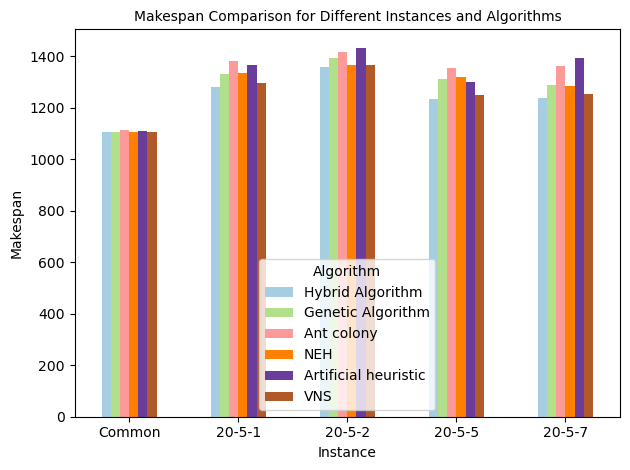

In [23]:
# Library Import(numpy and matplotlib)
import numpy as np 
import matplotlib.pyplot as plot 

plt.figure(figsize=(5,5))
df.plot(kind='bar', colormap='Paired');

# Set plot labels and title
plt.xlabel('Instance')
plt.ylabel('Makespan')
plt.title('Makespan Comparison for Different Instances and Algorithms', fontsize=10)
plt.xticks(rotation=0)
plt.savefig('pop_meta.png')
plt.tight_layout()
plt.show()

# Remarks

Based on the observed outcomes, we notice that VNS (Variable Neighborhood Search) consumed the highest amount of time. This can be attributed to the utilization of the 'method' parameter set to random. This implies that during each iteration, a neighboring function is randomly selected from the pool of six available functions. In the case of larger instances (consisting of more than ten jobs), neighboring functions like best_swap or best_insertion tend to require a substantial amount of time for execution.

By considering random_swap as the neighboring function for all iterations, it can be observed that the overall time is significantly reduced. However the makespan achieved isn't that good compared to the one obtained above.

In [127]:
def vns(sol_init, processing_times, max_iterations, k_max):
    num_jobs = len(sol_init)
    current_solution = sol_init
    current_cost = evaluate_sequence(current_solution, processing_times)
    k = 1
    iteration = 0
    while iteration < max_iterations:       
        # Appliquer la perturbation "shake" pour générer le voisin aléatoire
        best_neighbor_solution = shake_VNS(current_solution, k)
        best_neighbor_cost = evaluate_sequence(best_neighbor_solution, processing_times)
        
        # Parcourir les voisins pour trouver la meilleure solution locale
        for l in range(1, k_max+1):
            neighbor, neighbor_cost  = get_neighbor(current_solution, processing_times, method='random_swap')
            if (neighbor_cost < best_neighbor_cost):
                best_neighbor_solution = neighbor
                best_neighbor_cost = neighbor_cost            
        if ( best_neighbor_cost < current_cost ):
            current_solution = best_neighbor_solution
            current_cost = best_neighbor_cost
            k = 1
        else:
            k += 1
        iteration += 1
    return current_solution, current_cost

In [128]:
start_time = time.time()
sol, Cmax = vns(neh_20_5_0, instance_20_5_0, 100, 5)
elapsed_time = time.time() - start_time

print(f'\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")


Generated Solution: [8, 12, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 4, 11, 0, 18, 5, 9, 6, 19].
Makespan: 1305.0

Elapsed time:  0.17364192008972168 seconds
